# Sentiment Analysis

## Experiments with BERT models

In this notebook are my experiments developing the sentiment classifier for the IMDb reviews dataset using the BERT-based model available on Hugging Face. I modified the BERT model for sequence classification, then fine-tuned its hyperparameters. Additionaly, I explore the impact of different sequence lengths and experiment with different BERT-based models such as BERT-base, BERT-large and DistilBert.

### Libraries

Importing the necessary libraries.

In [1]:
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Numpy, Plotting, Metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import random

# Testing and metrics
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

# BERT
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup, logging
logging.set_verbosity_error()

# Metal to run it locally on apple silicon, it falls back to CUDA online, else CPU as final resort
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'

Defining the function for reproducibility, by setting a fixed seed. This makes the random numbers generated the same in every execution of the code, which ensures that the results are consistent and reproducible.

In [2]:
def seedTorch(seed=33):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

### Data Preprocessing & Preparation

Initially reading the data and splitting in train, validation and test data. Due to the high memory requirements of the BERT model, I have limited the size of the dataset to a smaller chunk of the provided IMDB reviews data. This allows me to run the notebook locally while still obtaining reliable results.

In [3]:
# Using \t as delimeter and reading with pandas 
df = pd.read_csv("./imdb-reviews.csv", sep = '\t')
X = df['review']
Y = df[['rating']].copy()

# classify the ratings as positive and negative
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

# I will reserve 8% of the samples for testing and 10% for validation
train_X, val_X, test_X = X[:int(len(X)*0.32)], X[int(len(X)*0.32):int(len(X)*0.42)], X[int(len(X)*0.42):int(len(X)*0.5)]
train_Y, val_Y, test_Y = Y[:int(len(Y)*0.32)], Y[int(len(Y)*0.32):int(len(Y)*0.42)], Y[int(len(Y)*0.42):int(len(Y)*0.5)]

# Unique returns the mapping sorted
labelsMapping, indexed_labels_train = np.unique(train_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_val = np.unique(val_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_test = np.unique(test_Y['rating'], return_inverse=True)

Then loading the BERT-base uncased tokenizer.

In [4]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Then defining the function to preprocess the reviews by applying the BERT tokenizer's encode_plus method to tokenize and pad the review to prepare the data for the BERT-based model. This ensures that each review is tokenized, padded and truncated to a fixed length, which is necessary for efficient batching and training. The function returns the input IDs and attention masks as PyTorch tensors.

In [ ]:
# Returns input_ids and attention_masks for BERT
def preprocess(reviews, max_length):

    ids = []
    masks = []
    for review in reviews:
        encoding = tokenizer.encode_plus(
            text=review,
            max_length=max_length,
            truncation=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            padding='max_length',
            add_special_tokens=True
        ) 
        ids.append(encoding['input_ids'])
        masks.append(encoding['attention_mask'])
    return torch.tensor(ids), torch.tensor(masks)

Then defining the custom dataset class to be used for the BERT model.

In [ ]:
# A custom Dataset class to use for the dataloaders
class CustomDataset(Dataset):

    def __init__(self, reviews, labels, length):
        ids, masks = preprocess(reviews, length)
        self.input_ids = ids
        self.attention_masks = masks 
        self.labels = torch.tensor(labels)
        self.samples = labels.shape[0]

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        return { 'input_ids': self.input_ids[idx], 'attention_mask': self.attention_masks[idx] , 'labels': self.labels[idx]}

Then in order to get an idea of what max length to use for the encoding I will examine the token lengths of each review and display the distribution of token counts across all the reviews in the dataset. This should give me an idea about the average length of reviews and the range of variation in their lengths.

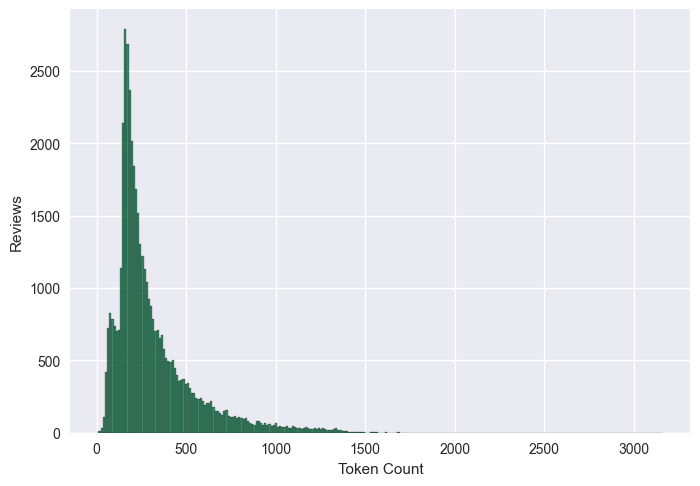

In [6]:
# Collecting the token lengths of each review
lengths = []
for review in X:
    lengths.append(len(tokenizer.encode(review)))

# Plotting them with a histogram
plt.style.use("seaborn-v0_8")
ax = sns.histplot(lengths, color = "#036638")
ax.set(xlabel='Token Count', ylabel='Reviews')
plt.show()

The distribution of token counts indicates that the majority of reviews in the dataset have less than 250 tokens. This is good to know because during initial experiments, I encountered issues with the kernel crashing when running larger max sizes due to the size of BERT. Therefore, I will set the max length to 64, which is a good middle ground that balances the need to cover longer reviews with the constraints on my available resources.

Now for the batch size according to the Hugging Face documentation, a size of 16 or 32 is recommended. This is good since due to memory limitations, I found it impossible to use a larger batch size anyway. I have settled on a batch size of 32, which looked as a reasonable choices that allowed me to achieve good results without the need of a long training time locally.

In [7]:
MAX_LENGTH = 64
BATCH_SIZE = 32

# Tokenizing, preprocessing and dataset creation
train_dataset = CustomDataset(train_X, indexed_labels_train, MAX_LENGTH)
val_dataset = CustomDataset(val_X, indexed_labels_val, MAX_LENGTH)
test_dataset = CustomDataset(test_X, indexed_labels_test, MAX_LENGTH)

# Corresponding Dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

### BERT Model

For the initial model I used the BERT-base-uncased pre-trained model and then a sequential neural network consisting of a linear layer, a ReLU activation function, a dropout layer and a final linear layer mapping to the number of output classes, which in this case are two positive and negative sentiment.

In [9]:
# Classifier Model using BERT
class BERT(nn.Module):
    
    def __init__(self, hidden_size, classes_size, dropout=0.1):
        super(BERT, self).__init__()
        self.model = BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.linear_stack = nn.Sequential(
            nn.Linear(self.model.config.hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, classes_size)
        )

    def forward(self, input_ids, attention_mask): 
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return self.linear_stack(output[0][:,0,:])

Then defining the necessary functions to automate the training process. These functions are similar to the ones I used in the previous three models. The function `train_epoch` is used to train the model for one epoch, `train_model` to train the model for a specific number epochs and `evaluation_function` to evaluate the performance of the trained model on the set provided. Finally, the `confusionMatrix` and `rocCurve` functions are used to visualize the model's performance using confusion matrix and ROC curve respectively.

In [12]:
# Function to train for one epoch
def train_epoch(optimizer, scheduler, dataloader, lossfunc, model, device, display=True, clip_value =1.0):

    model = model.train()
    losses = []

    # For each batch
    for batch, data in enumerate(dataloader):

        # In case the GPU is used
        ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)
        
        # Predict and calculate loss
        predictions = model(input_ids=ids, attention_mask=mask)
        loss = lossfunc(predictions, labels)
        losses.append(loss.item())

        # Inform the weights
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # When display is set print every 64 the loss
        if(display):
            if batch % 64 == 0:
                size = len(dataloader.dataset)
                loss, current = loss.item(), batch * len(ids)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # Return the total mean loss
    meanloss = 0
    if len(losses)!=0:
        meanloss = sum(losses)/len(losses)
    return meanloss
 
# Function to train a model
def train_model(epochs, optimizer, scheduler, dataloader, lossfunc, model, device, display=True, clip_value=1.0):

    # For each epoch
    for epoch in range(epochs):
        if (display):
            print(f"\nEpoch {epoch+1}\n_________________________________")
        train_epoch(optimizer, scheduler, dataloader, lossfunc, model, device, display, clip_value)
        if (display):
            print("_________________________________")
        
    # Returns the model
    return model

# Evaluation function
def evaluation_function(dataloader, model, lossfunc, device, display=True):

    # Variable initialisation
    correctCount = 0
    sampleCount = 0
    losses = []
    preds = []
    trues = []
    probs = []

    # So the model is in eval mode
    model.eval()
    with torch.no_grad():

        # For each batch
        for batch, data in enumerate(dataloader):

            # In case the GPU is used
            ids = data['input_ids'].to(device)
            mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)
            
            # Predict and calculate loss
            scores = model(input_ids=ids, attention_mask=mask)
            _ , predictions = torch.max(scores, dim=1)
            loss = lossfunc(scores, labels)
            losses.append(loss.item())
        
            # Probability estimates of the positive class
            probs_pos = torch.sigmoid(scores[:,1]).cpu()
 
            # Saving them for the metrics later
            predictions= torch.abs(predictions.cpu())
            labels=labels.cpu()
            probs.extend(probs_pos.numpy())
            preds.extend(predictions.numpy())
            trues.extend(labels.numpy())
            correctCount += (predictions==labels).sum()
            sampleCount += predictions.size(0)

    # Metric calculations
    f1macro = f1_score(y_pred=torch.tensor(preds), y_true=torch.tensor(trues), average="macro").item() * 100
    accuracy = float(correctCount) / float(sampleCount) * 100
    meanloss = sum(losses)/len(losses)
    recall = recall_score(y_true=trues, y_pred=preds) * 100
    precision = precision_score(y_true=trues, y_pred=preds) * 100

    # Printing them if display is not false
    if display:
        print("\nEvaluation Results")
        print("_________________________________")
        print(
            f"Predicted {correctCount} / {sampleCount} correctly"
            f"\nMean Loss: {meanloss:.2f} "
            f"\nRecall: {recall:.2f}%"
            f"\nPrecision: {precision:.2f}%"
            f"\nAccuracy: {accuracy:.2f}%"
            f"\nMacro Averaged F1-score: {f1macro:.2f}%"
            )
        print("_________________________________")

    # Reset the model to train mode
    model.train()

    return trues, preds, probs ,meanloss, accuracy, f1macro, recall, precision

# Confusion Matrix plotting
def confusionMatrix(trues, preds):
    names =[labelsMapping[0], labelsMapping[1]]
    cfmatr = confusion_matrix(trues, preds)
    df_cm = pd.DataFrame(cfmatr/np.sum(cfmatr) * 2, index = [i for i in names],
                     columns = [i for i in names])
    plt.figure(figsize = (9,9))
    sns.heatmap(df_cm, cmap='viridis_r', annot=True)
    plt.show()

# Roc Curve plotting and also returns roc auc score
def rocCurve(trues, preds, probs):
    false_positive_rate, true_positive_rate, threshold = roc_curve(trues, probs)
    roc_auc = roc_auc_score(trues, preds)
    plt.style.use("seaborn-v0_8")
    plt.subplots(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label="AUC="+str(roc_auc))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7") 
    plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc

First, I'll train the model for one epoch. This may not be enough for the model to converge and learn the patterns in the data, but I only want to examine that the training functions work correctly. The hyperparameters used are ones suggested in the Hugging Face documentation for optimal performance and which I found in previous experiments to work quite well.

In [11]:
EPOCHS = 1
HIDDEN_SIZE = 32
CLASSES = 2
DROPOUT = 0.2
LEARNING_RATE = 5e-5
EPSILON = 1e-9
CLIP_VALUE = 0.8

# Instaniate the model
seedTorch()
model = BERT(HIDDEN_SIZE, CLASSES, DROPOUT).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
model = train_model(EPOCHS,optimizer, scheduler, train_dataloader, lossfunc, model, device, True, CLIP_VALUE)
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')


Epoch 1
_________________________________
loss: 0.681084  [    0/14402]
loss: 0.429861  [ 2048/14402]
loss: 0.653745  [ 4096/14402]
loss: 0.557114  [ 6144/14402]
loss: 0.501672  [ 8192/14402]
loss: 0.417217  [10240/14402]
loss: 0.513946  [12288/14402]
loss: 0.432108  [14336/14402]
_________________________________
Training Time: 5.13 minutes


The training took five minutes which is not that long even though I'm using a reduced dataset. The loss also seems to decrease so the model is learning. Then I'll evaluate on the test set to make sure this function works correctly too.


Evaluation Results
_________________________________
Predicted 3020 / 3601 correctly
Mean Loss: 0.35 
Recall: 84.30%
Precision: 83.70%
Accuracy: 83.87%
Macro Averaged F1-score: 83.86%
_________________________________


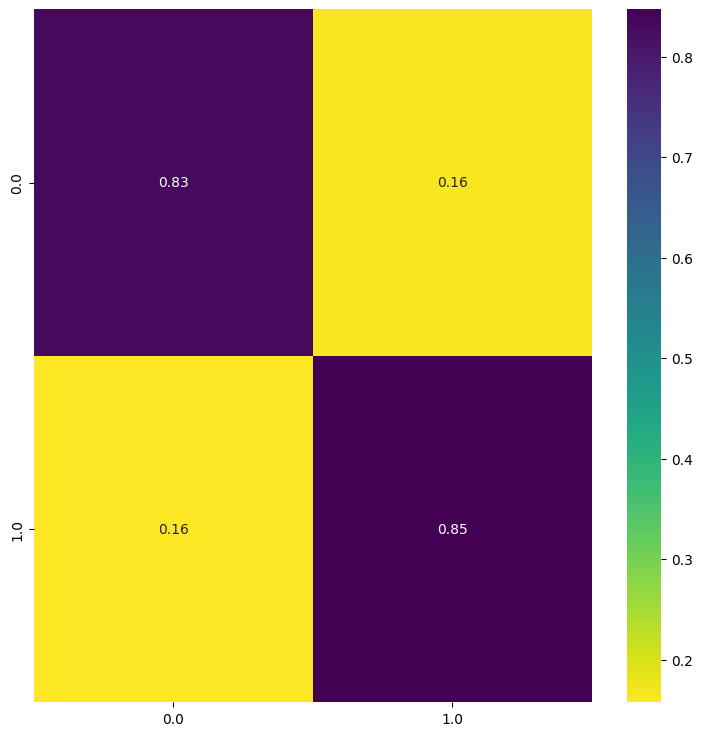

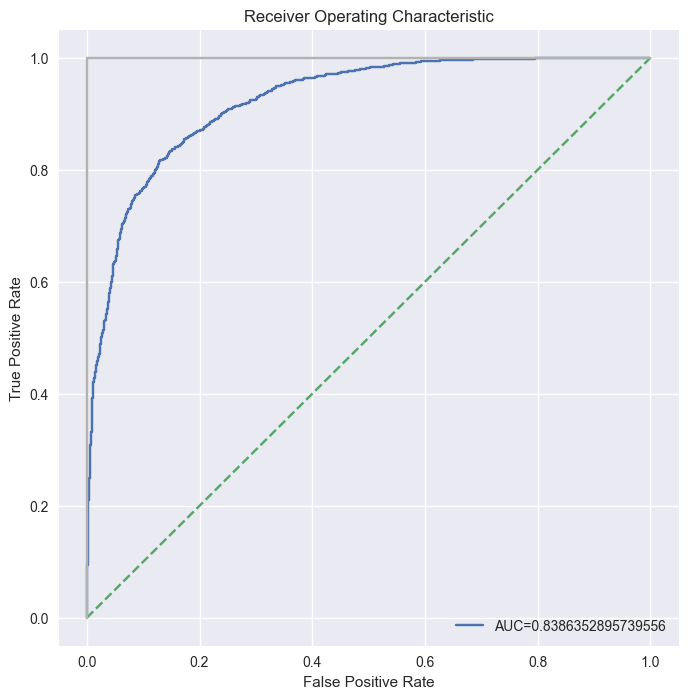

In [12]:
# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluation_function(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Even after only one epoch yhe BERT-based model achieved promising results. The mean loss of 0.35 indicates that it is minimizing the difference between predicted and actual labels and it has a recall of 84.30%, precision of 83.70% and accuracy of 83.87% on the test set, which are also very encouraging. The macro-averaged F1-score of 83.86% further confirms the strong performance of the model, while it achieved a ROC AUC score of 83.87%, indicating that it has a high ability to distinguish between positive and negative sentiment.

These results suggest that even in this initial form the model is effective in accurately classifying sentiment in text. Then, I'll build on these promising results by further optimizing the model and exploring additional hyperparameter configurations.

### Fine-tuning the Model

Following this I'll tune the hyperparameters. I define the function `optimal_model` to automate the process of finding the best model for the given dataset by training the model and evaluating it for each epoch. By keeping track of the best model based on the macro-averaged F1-score on the validation set, if a better one is found I save the best model. Also in the end the learning curve is plotted of the training and validation loss for each epoch.

In [13]:
# Function automating finding the best model
def optimal_model(device, model, epochs, train_dataloader, val_dataloader, optimizer, scheduler, lossfunc, display=False, clip_value = 0.6):

    # Variable initialisation
    bestf1=0
    bestepoch=0
    trainlosses = []
    validlosses = []
    average = 0
    
    # For each epoch
    for epoch in range(epochs):

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        
        # Train the model
        meanLoss = train_epoch(optimizer, scheduler, train_dataloader, lossfunc,  model, device, display, clip_value)

        # Evaluation
        _, _, _, meanlossval, accura, macrof1, _, _ = evaluation_function(val_dataloader, model, lossfunc, device, display)

        if (display):
            print("Training loss: ", meanLoss , " Validation loss: ", meanlossval, " Accuracy: ", accura)
    
        trainlosses.append(meanLoss)
        validlosses.append(meanlossval)
        average += abs(meanLoss-meanlossval)
        
        # If f1 score is better
        if (bestf1<macrof1):
            bestepoch=epoch
            bestf1=macrof1

            # Save the model
            torch.save(model.state_dict(), './best_model.pt')
    
        if(display):
            print("__________________________________")

    print("Training loss - validation loss average difference: ", abs(average/len(trainlosses)))

    x = list(range(0, len(trainlosses)))
    plt.style.use("seaborn-v0_8")
    plt.plot(x, trainlosses, linestyle="-", label="Training")
    plt.plot(x, validlosses, linestyle="-", label="Validation")
    plt.legend()
    plt.show()

    return bestepoch

Then training using the optimal model function for five epochs, so that by plotting the learning curve at the end I can see if the model has a tendency to underfit or overfit. The scheduler also this time is going to come into play with the `get_linear_schedule_with_warmup` provided by the Hugging Face transformers library that creates a linear scheduler with warmup. This updates the learning rate linearly from 0 to the initial learning rate.

Epoch 1
__________________________________
loss: 0.697160  [    0/14402]
loss: 0.330437  [ 2048/14402]
loss: 0.362482  [ 4096/14402]
loss: 0.553179  [ 6144/14402]
loss: 0.398422  [ 8192/14402]
loss: 0.394413  [10240/14402]
loss: 0.400950  [12288/14402]
loss: 0.301665  [14336/14402]

Evaluation Results
_________________________________
Predicted 3722 / 4501 correctly
Mean Loss: 0.39 
Recall: 86.71%
Precision: 80.43%
Accuracy: 82.69%
Macro Averaged F1-score: 82.66%
_________________________________
Training loss:  0.4459820688431649  Validation loss:  0.39010474265467193  Accuracy:  82.69273494778938
__________________________________
Epoch 2
__________________________________
loss: 0.305106  [    0/14402]
loss: 0.226642  [ 2048/14402]
loss: 0.347918  [ 4096/14402]
loss: 0.225985  [ 6144/14402]
loss: 0.170748  [ 8192/14402]
loss: 0.566897  [10240/14402]
loss: 0.177069  [12288/14402]
loss: 0.201545  [14336/14402]

Evaluation Results
_________________________________
Predicted 3712 / 4501 

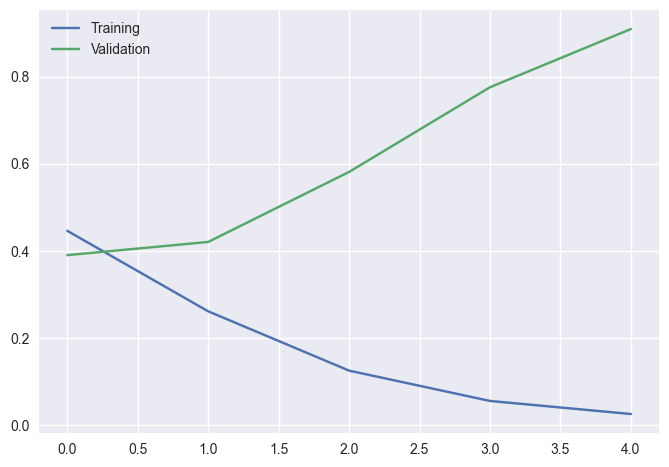

Best F1 score after  3  epochs.
Training Time: 24.50 minutes


In [16]:
EPOCHS = 5
HIDDEN_SIZE = 48
CLASSES = 2
DROPOUT = 0.2
LEARNING_RATE = 5e-5
EPSILON = 1e-9
CLIP_VALUE = 0.8

# Instaniate the model
seedTorch()
model = BERT(HIDDEN_SIZE, CLASSES, DROPOUT).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
best_epoch = optimal_model(device, model, EPOCHS, train_dataloader, val_dataloader, optimizer, scheduler, lossfunc, True, CLIP_VALUE)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

It looks like the model is improving in terms of training loss, but the validation loss seems to be increasing after the second epoch. This could be a sign of overfitting to the training data and not generalizing well. So an early stopping technique could be valuable. 

The evaluation metrics show that the accuracy is consistently above 80%, but the macro-averaged F1 score seems to be decreasing after the second epoch, which could also indicate overfitting. Some possible ways to address overfitting also is to add regularization by increasing the dropout probability, to increase the amount of data or to reduce the complexity of the model. Before that I will also evaluate on the test set.


Evaluation Results
_________________________________
Predicted 3038 / 3601 correctly
Mean Loss: 0.72 
Recall: 84.58%
Precision: 84.34%
Accuracy: 84.37%
Macro Averaged F1-score: 84.36%
_________________________________


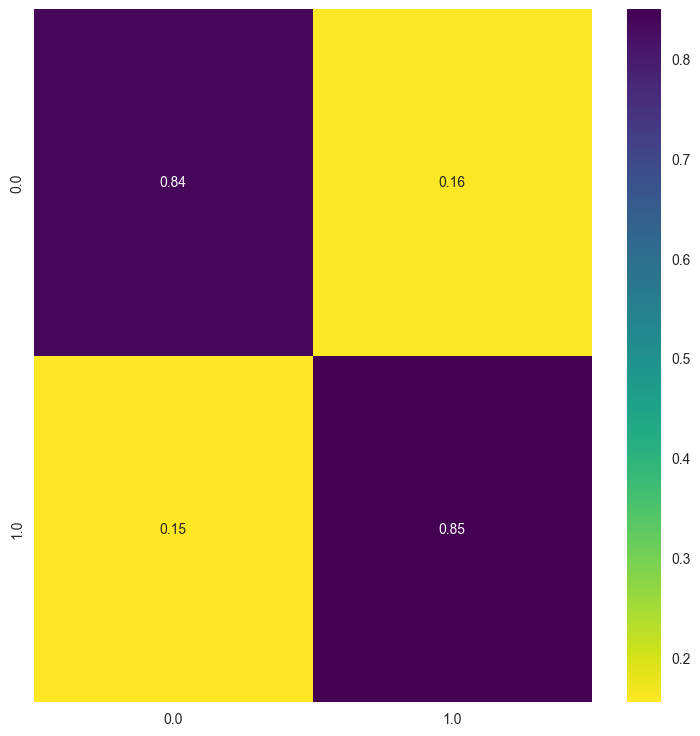

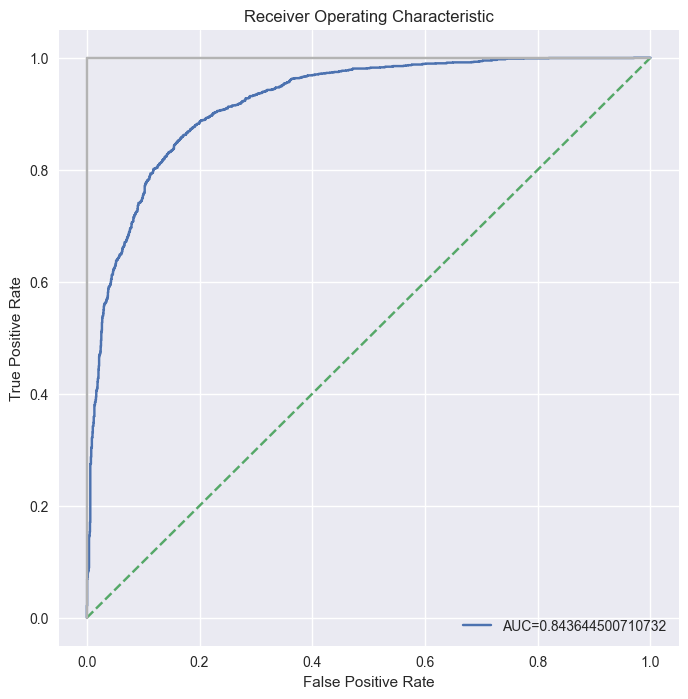

In [17]:
# Load the best model found before
seedTorch()
model = BERT(HIDDEN_SIZE, CLASSES, DROPOUT).to(device)
model.load_state_dict(torch.load('./best_model.pt'))

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluation_function(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The model performs fairly well achieving an accuracy of 84% and both the recall and precision are relatively high, at 84.58% and 84.34% respectively. This indicates that the model is correctly identifying a high percentage of the positive cases while minimizing the number of false positives.

Based on the fact that the scores are very similar to the ones I got after training the model for only one epoch which indicated that the model in its current architecture stops learning after one epoch. Therefore, it's important to fine-tune the model further.

### Fine-tuning the hyperparameters

The recommended search space from the BERT authors is learning rate, batch size and epochs, but since batch size and epochs will be finetuned later, my focus will be on experimenting with the learning rate and hidden size as well as dropout probability.Since one epoch is enough to get an idea of how the model is performing as I saw from the previous trainings, the search can be done relatively quickly for each configuration. 

The learning rates: 5e-5, 3e-5, and 2e-5 were selected because they were suggested on the paper of the original authors of BERT. While for the dropout and hidden sizes I run a series of trials locally and on Colab to find the range of where the optimal values might be.

In [19]:
EPOCHS = 1
CLASSES = 2
CLIP_VALUE = 1.0

# Parameters to tune
hidden_sizes = [48, 96, 192]
dropout_probs = [0.1, 0.2]
learning_rates = [5e-5, 3e-5, 2e-5] 

# Best parameters
best_hidden_size = 0
best_dropout = 0 
best_lr = 0
best_f1_score = 0
iter = 1

for HIDDEN_SIZE in hidden_sizes:
    for DROPOUT in dropout_probs:
        for LEARNING_RATE in learning_rates:

            print("Trial ", iter,"\n__________\nHidden Size: ", HIDDEN_SIZE,", Dropout: ", DROPOUT, ", Learning Rate: ",LEARNING_RATE )
            iter+=1

            # Instaniate the model
            seedTorch()
            model = BERT(HIDDEN_SIZE, CLASSES, DROPOUT).to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
            scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
            lossfunc = nn.CrossEntropyLoss()

            # Train the model
            model = train_model(EPOCHS, optimizer, scheduler, train_dataloader, lossfunc, model, device, False, CLIP_VALUE)

            # Evaluate on the test set and print confusion matrix and roc curve
            trues, preds, probs, meanloss, acura, f1, recall, precision = evaluation_function(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device, display=True)

            if (f1>best_f1_score):
                best_f1_score = f1
                best_hidden_size = HIDDEN_SIZE
                best_dropout = DROPOUT
                best_lr = LEARNING_RATE

print("\nBest Parameters Found", iter,"\n____________\nHidden Size: ", best_hidden_size,", Dropout: ", best_dropout, ", Learning Rate: ",best_lr )
            

Trial  1 
__________
Hidden Size:  48 , Dropout:  0.1 , Learning Rate:  5e-05

Evaluation Results
_________________________________
Predicted 3013 / 3601 correctly
Mean Loss: 0.36 
Recall: 83.20%
Precision: 84.13%
Accuracy: 83.67%
Macro Averaged F1-score: 83.67%
_________________________________
Trial  2 
__________
Hidden Size:  48 , Dropout:  0.1 , Learning Rate:  3e-05

Evaluation Results
_________________________________
Predicted 2989 / 3601 correctly
Mean Loss: 0.36 
Recall: 83.25%
Precision: 82.98%
Accuracy: 83.00%
Macro Averaged F1-score: 83.00%
_________________________________
Trial  3 
__________
Hidden Size:  48 , Dropout:  0.1 , Learning Rate:  2e-05

Evaluation Results
_________________________________
Predicted 2950 / 3601 correctly
Mean Loss: 0.38 
Recall: 83.75%
Precision: 80.93%
Accuracy: 81.92%
Macro Averaged F1-score: 81.91%
_________________________________
Trial  4 
__________
Hidden Size:  48 , Dropout:  0.2 , Learning Rate:  5e-05

Evaluation Results
___________

The best hyperparameter configuration found after these trials were Hidden Size: 96, Dropout: 0.1 and Learning Rate: 5e-05. Though looking of how close all of the scores were suggests, that the model has similar performance by having any value around these ranges. Then I'll use these hyperparameters to train the model for four epochs to find the best snapshot.

Epoch 1
__________________________________
loss: 0.698862  [    0/14402]
loss: 0.430817  [ 2048/14402]
loss: 0.543384  [ 4096/14402]
loss: 0.483124  [ 6144/14402]
loss: 0.445444  [ 8192/14402]
loss: 0.463631  [10240/14402]
loss: 0.309148  [12288/14402]
loss: 0.312814  [14336/14402]

Evaluation Results
_________________________________
Predicted 3726 / 4501 correctly
Mean Loss: 0.38 
Recall: 85.65%
Precision: 81.17%
Accuracy: 82.78%
Macro Averaged F1-score: 82.76%
_________________________________
Training loss:  0.43665981474446086  Validation loss:  0.3770151235533099  Accuracy:  82.78160408798045
__________________________________
Epoch 2
__________________________________
loss: 0.187416  [    0/14402]
loss: 0.257390  [ 2048/14402]
loss: 0.304430  [ 4096/14402]
loss: 0.316453  [ 6144/14402]
loss: 0.209183  [ 8192/14402]
loss: 0.202068  [10240/14402]
loss: 0.364239  [12288/14402]
loss: 0.329020  [14336/14402]

Evaluation Results
_________________________________
Predicted 3694 / 4501 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG13XFamilyCommandBuffer: 0x2d98d21a0>
    label = <none> 
    device = <AGXG13XDevice: 0x13d6dc800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x2b3c07c00>
        label = <none> 
        device = <AGXG13XDevice: 0x13d6dc800>
            name = Apple M1 Pro 
    retainedReferences = 1


loss: 0.238406  [12288/14402]
loss: 0.035774  [14336/14402]

Evaluation Results
_________________________________
Predicted 3715 / 4501 correctly
Mean Loss: 0.65 
Recall: 84.77%
Precision: 81.32%
Accuracy: 82.54%
Macro Averaged F1-score: 82.52%
_________________________________
Training loss:  0.1041598808218595  Validation loss:  0.6473271879532658  Accuracy:  82.53721395245502
__________________________________
Epoch 4
__________________________________
loss: 0.118048  [    0/14402]
loss: 0.146543  [ 2048/14402]
loss: 0.185987  [ 4096/14402]
loss: 0.009911  [ 6144/14402]
loss: 0.138611  [ 8192/14402]
loss: 0.003057  [10240/14402]
loss: 0.197414  [12288/14402]
loss: 0.002540  [14336/14402]

Evaluation Results
_________________________________
Predicted 3741 / 4501 correctly
Mean Loss: 0.84 
Recall: 82.83%
Precision: 83.49%
Accuracy: 83.11%
Macro Averaged F1-score: 83.11%
_________________________________
Training loss:  0.040257065870309715  Validation loss:  0.8405379006203185  Accur

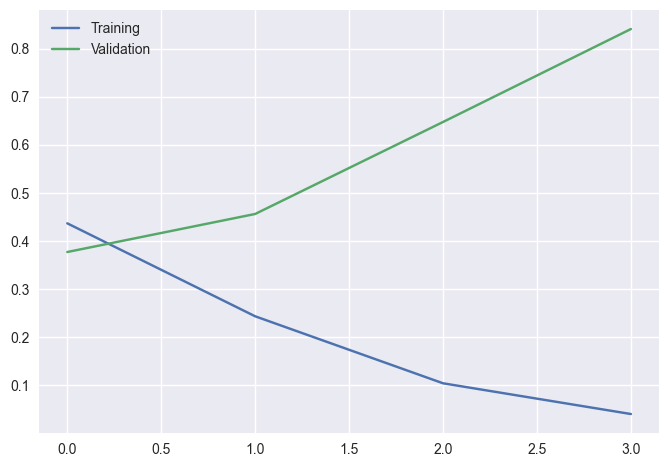

Best F1 score after  3  epochs.
Training Time: 32.17 minutes


In [26]:
EPOCHS = 4
CLASSES = 2
DROPOUT = 0.1
LEARNING_RATE = 5e-5
CLIP_VALUE = 1.0
HIDDEN_SIZE = 96

# Instaniate the model
seedTorch()
model = BERT(HIDDEN_SIZE, CLASSES, DROPOUT).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
best_epoch = optimal_model(device, model, EPOCHS, train_dataloader, val_dataloader, optimizer, scheduler, lossfunc, True, CLIP_VALUE)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

The model seems to be able to learn, but it still looks like it's overfitting after a certain point. So this learning curve shows that the hyperparameters may have made a difference, but an increase in training size is crucial to combat this. Then I evaluate on the test set.


Evaluation Results
_________________________________
Predicted 3035 / 3601 correctly
Mean Loss: 0.76 
Recall: 84.47%
Precision: 84.28%
Accuracy: 84.28%
Macro Averaged F1-score: 84.28%
_________________________________


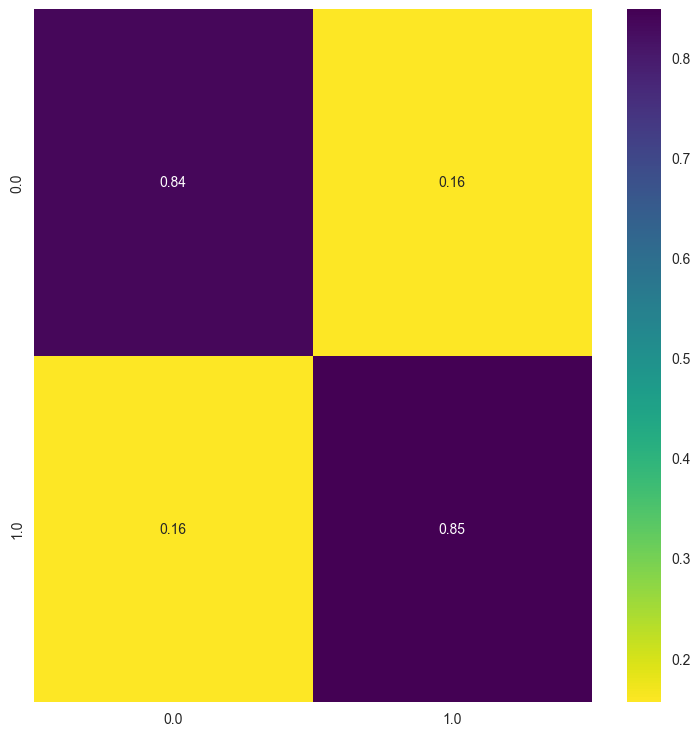

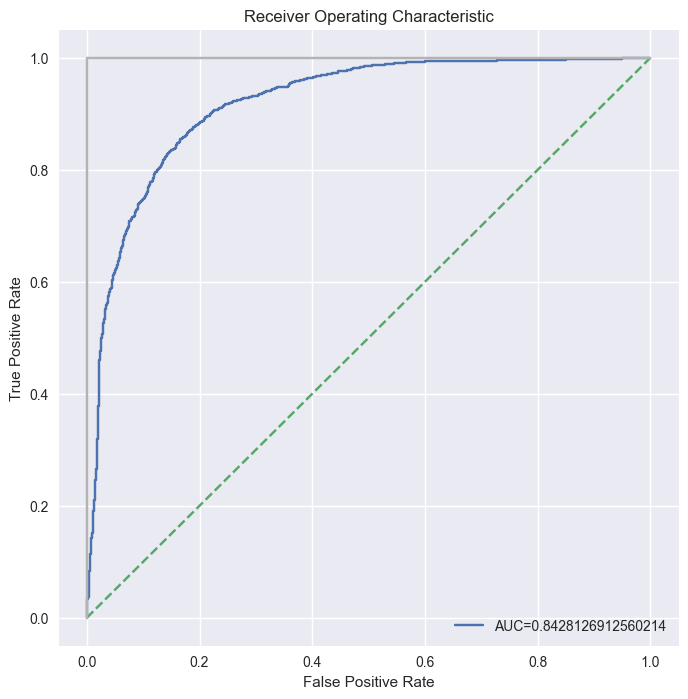

In [27]:
# Load the best model found before
seedTorch()
model = BERT(HIDDEN_SIZE ,CLASSES, DROPOUT).to(device)
model.load_state_dict(torch.load('./best_model.pt'))

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluation_function(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The configuration of these hyperparameters of the model shows good performance on the test set, having an overall accuracy of 84.28% and an F1-score of 84.28%. However, there is still room for improvement and to make the model better at generalising, before increasing the data, I will experiment with a more simplified architecture.

### Simplifying the Sequential Architecture

To confirm if my suspicion is correct I will simplify the model by removing one linear layer. This new model, BERT_02, has only one linear layer and uses dropout regularization before the input of the linear layer this time to prevent overfitting.

In [23]:
# Classifier Model using BERT
class BERT_02(nn.Module):
    
    def __init__(self, classes_size, dropout=0.1):
        super(BERT_02, self).__init__()
        self.model = BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.linear_stack = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.model.config.hidden_size, classes_size)
        )

    def forward(self, input_ids, attention_mask): 
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return self.linear_stack(output[0][:,0,:])

Then training this model for four epochs, using optimal model to save the best model found.

Epoch 1
__________________________________
loss: 0.703320  [    0/14402]
loss: 0.503441  [ 2048/14402]
loss: 0.546581  [ 4096/14402]
loss: 0.407587  [ 6144/14402]
loss: 0.316236  [ 8192/14402]
loss: 0.196428  [10240/14402]
loss: 0.423957  [12288/14402]
loss: 0.305391  [14336/14402]

Evaluation Results
_________________________________
Predicted 3719 / 4501 correctly
Mean Loss: 0.38 
Recall: 85.25%
Precision: 81.17%
Accuracy: 82.63%
Macro Averaged F1-score: 82.61%
_________________________________
Training loss:  0.43210477079626197  Validation loss:  0.37929203641330095  Accuracy:  82.62608309264607
__________________________________
Epoch 2
__________________________________
loss: 0.266158  [    0/14402]
loss: 0.204298  [ 2048/14402]
loss: 0.153016  [ 4096/14402]
loss: 0.162899  [ 6144/14402]
loss: 0.199723  [ 8192/14402]
loss: 0.377138  [10240/14402]
loss: 0.458981  [12288/14402]
loss: 0.220226  [14336/14402]

Evaluation Results
_________________________________
Predicted 3739 / 4501

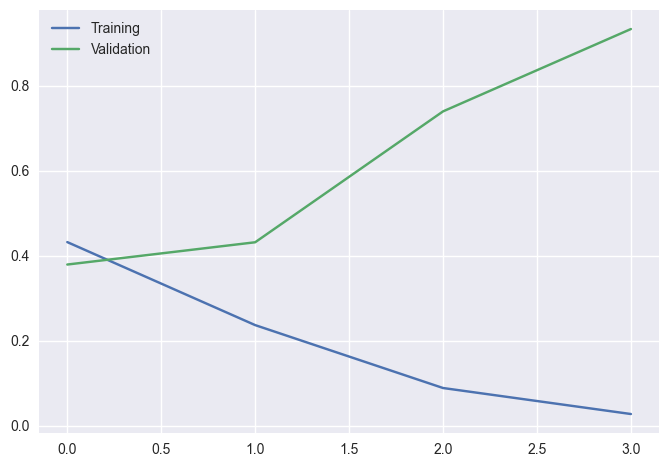

Best F1 score after  3  epochs.
Training Time: 28.39 minutes


In [24]:
EPOCHS = 4
CLASSES = 2
DROPOUT = 0.1
LEARNING_RATE = 5e-5
CLIP_VALUE = 1.0

# Instaniate the model
seedTorch()
model = BERT_02(CLASSES, DROPOUT).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
best_epoch = optimal_model(device, model, EPOCHS, train_dataloader, val_dataloader, optimizer, scheduler, lossfunc, True, CLIP_VALUE)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

From the learning curve it doesn't look that this simplified approach made much difference as it is quite similar to the one before. I will also evaluate on the test set to see if the performance improved.


Evaluation Results
_________________________________
Predicted 3027 / 3601 correctly
Mean Loss: 0.87 
Recall: 83.97%
Precision: 84.25%
Accuracy: 84.06%
Macro Averaged F1-score: 84.06%
_________________________________


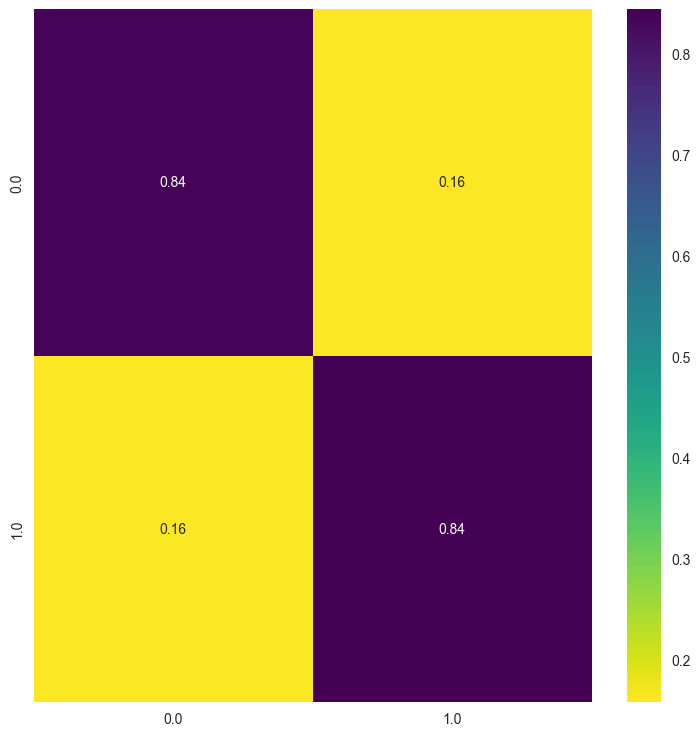

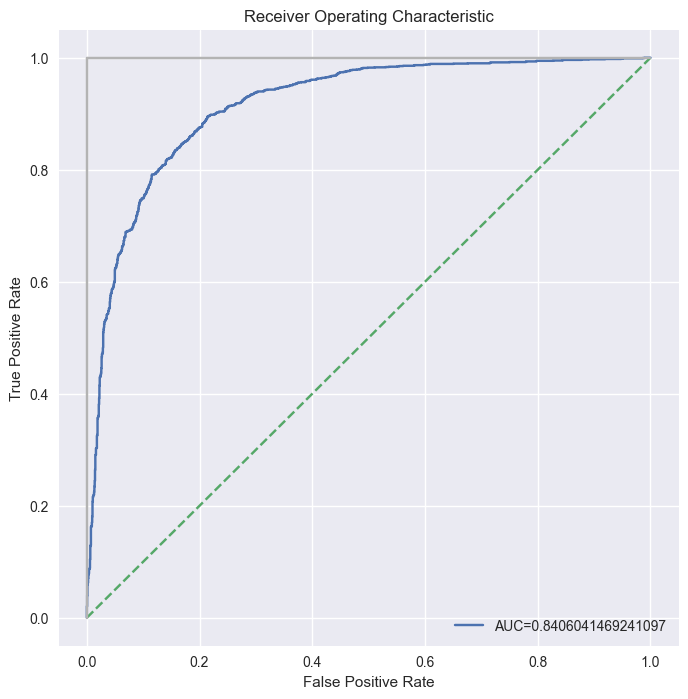

In [25]:
# Load the best model found before
seedTorch()
model = BERT_02(CLASSES, DROPOUT).to(device)
model.load_state_dict(torch.load('./best_model.pt'))

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluation_function(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The performance is still the same after simplifying the network's architecture. One possibility is that the additional linear layer was not causing overfitting, so removing it made no difference to the model's ability to generalize. Maybe also removing it led to a decrease in the model's capacity and performance. 

### DistilBERT

It might be that the model so far is already at its best performance and it requires an increase in the data to be better able to generalise. But first I will experiment with a smaller BERT variant, DistilBERT, to reduce computation time and compare its performance to the larger BERT model before scaling up the dataset.

In [5]:
from transformers import DistilBertTokenizerFast, DistilBertModel
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Then defining the same model as before with the simplified architecture, but using Distilbert-Base uncased this time. As it says in Hugging Face DistilBERT is a smaller and faster version of BERT that uses parameter sharing to reduce the model size while maintaining similar performance, which makes it a good choice for situations where computational resources are limited.

In [53]:
# Classifier Model using BERT cased
class BERT_03(nn.Module):
    
    def __init__(self, classes_size, dropout=0.1):
        super(BERT_03, self).__init__()
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased", return_dict=False)
        self.linear_stack = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.model.config.hidden_size, classes_size)
        )

    def forward(self, input_ids, attention_mask): 
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return self.linear_stack(output[0][:,0,:])

Then training for three epochs with the same parameters as before.

In [56]:
EPOCHS = 3
CLASSES = 2
DROPOUT = 0.1
LEARNING_RATE = 5e-5
CLIP_VALUE = 1.0

# Instaniate the model
seedTorch()
model = BERT_03(CLASSES, DROPOUT).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
model = train_model(EPOCHS,optimizer, scheduler, train_dataloader, lossfunc, model, device, True, CLIP_VALUE)
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')


Epoch 1
_________________________________
loss: 0.675200  [    0/14402]
loss: 0.415728  [ 2048/14402]
loss: 0.561721  [ 4096/14402]
loss: 0.416045  [ 6144/14402]
loss: 0.460422  [ 8192/14402]
loss: 0.374466  [10240/14402]
loss: 0.338558  [12288/14402]
loss: 0.394656  [14336/14402]
_________________________________

Epoch 2
_________________________________
loss: 0.247721  [    0/14402]
loss: 0.444707  [ 2048/14402]
loss: 0.262830  [ 4096/14402]
loss: 0.379849  [ 6144/14402]
loss: 0.238568  [ 8192/14402]
loss: 0.485467  [10240/14402]
loss: 0.176401  [12288/14402]
loss: 0.274426  [14336/14402]
_________________________________

Epoch 3
_________________________________
loss: 0.133954  [    0/14402]
loss: 0.121216  [ 2048/14402]
loss: 0.157028  [ 4096/14402]
loss: 0.056006  [ 6144/14402]
loss: 0.146569  [ 8192/14402]
loss: 0.089825  [10240/14402]
loss: 0.034738  [12288/14402]
loss: 0.063078  [14336/14402]
_________________________________
Training Time: 13.75 minutes


The model seems to learn with the loss steadily decreasing. Then evaluating on the test set.


Evaluation Results
_________________________________
Predicted 2995 / 3601 correctly
Mean Loss: 0.55 
Recall: 83.03%
Precision: 83.40%
Accuracy: 83.17%
Macro Averaged F1-score: 83.17%
_________________________________


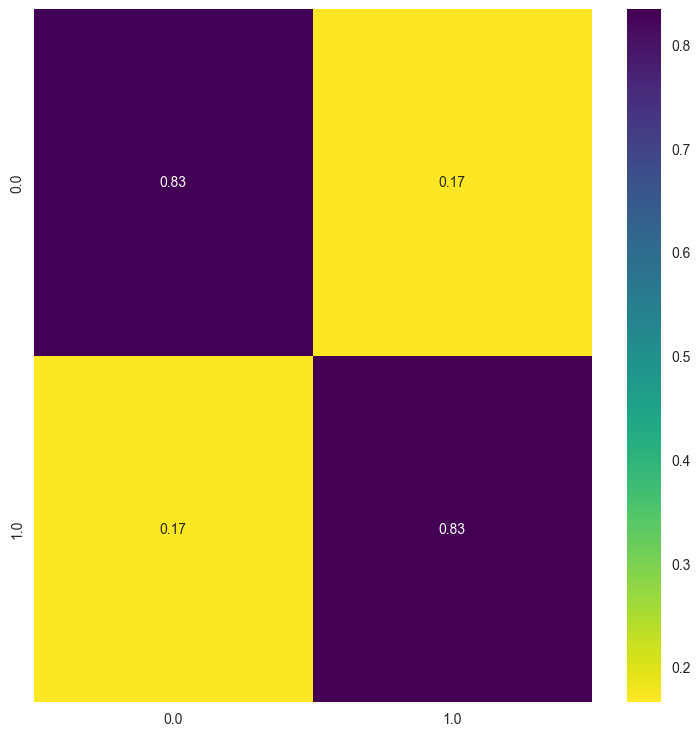

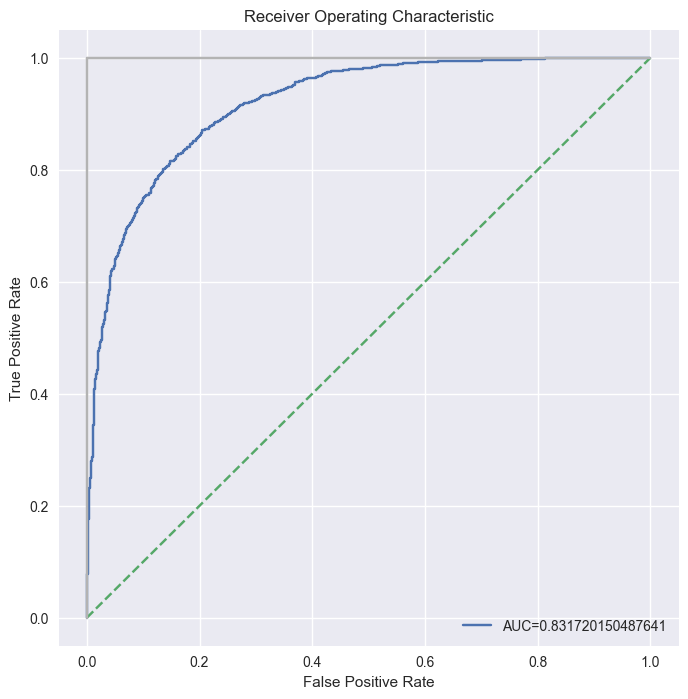

In [57]:
# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluation_function(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Based on the evaluation results, the DistilBERT model performed slightly worse than the BERT model with an accuracy of 83.17% compared to 84.28%. However, it trained faster which makes it a great choice for increasing the size of the data to see if this would achieve a better performance.

### Increasing the dataset

Now increasing the training dataset by using 80% of the IMDB data provided rather than 32%. This should help the model to generalize better and improve its performance.

In [61]:
# I will reserve 10% of the samples for testing and 10% for validation
train_X, val_X, test_X = X[:int(len(X)*0.8)], X[int(len(X)*0.8):int(len(X)*0.9)], X[int(len(X)*0.9):]
train_Y, val_Y, test_Y = Y[:int(len(Y)*0.8)], Y[int(len(Y)*0.8):int(len(Y)*0.9)], Y[int(len(Y)*0.9):]

# Unique returns the mapping sorted
labelsMapping, indexed_labels_train = np.unique(train_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_val = np.unique(val_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_test = np.unique(test_Y['rating'], return_inverse=True)

MAX_LENGTH = 64
BATCH_SIZE = 32

# Tokenizing, preprocessing and dataset creation
train_dataset = CustomDataset(train_X, indexed_labels_train, MAX_LENGTH)
val_dataset = CustomDataset(val_X, indexed_labels_val, MAX_LENGTH)
test_dataset = CustomDataset(test_X, indexed_labels_test, MAX_LENGTH)

# Corresponding Dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Then training the same model for three epochs with this increased dataset.

In [64]:
EPOCHS = 3
CLASSES = 2
DROPOUT = 0.1
LEARNING_RATE = 5e-5
CLIP_VALUE = 0.8

# Instaniate the model
seedTorch()
model = BERT_03(CLASSES, DROPOUT).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
model = train_model(EPOCHS,optimizer, scheduler, train_dataloader, lossfunc, model, device, True, CLIP_VALUE)
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')


Epoch 1
_________________________________
loss: 0.714780  [    0/36006]
loss: 0.419089  [ 2048/36006]
loss: 0.374994  [ 4096/36006]
loss: 0.378332  [ 6144/36006]
loss: 0.344832  [ 8192/36006]
loss: 0.598358  [10240/36006]
loss: 0.342927  [12288/36006]
loss: 0.358568  [14336/36006]
loss: 0.425948  [16384/36006]
loss: 0.264814  [18432/36006]
loss: 0.386529  [20480/36006]
loss: 0.778862  [22528/36006]
loss: 0.391016  [24576/36006]
loss: 0.504012  [26624/36006]
loss: 0.277728  [28672/36006]
loss: 0.519438  [30720/36006]
loss: 0.263034  [32768/36006]
loss: 0.574658  [34816/36006]
_________________________________

Epoch 2
_________________________________
loss: 0.255037  [    0/36006]
loss: 0.139503  [ 2048/36006]
loss: 0.164174  [ 4096/36006]
loss: 0.153383  [ 6144/36006]
loss: 0.104998  [ 8192/36006]
loss: 0.252325  [10240/36006]
loss: 0.359919  [12288/36006]
loss: 0.254807  [14336/36006]
loss: 0.234437  [16384/36006]
loss: 0.229967  [18432/36006]
loss: 0.217954  [20480/36006]
loss: 0.29

The training of three epochs for the model took 131.29 minutes compared to 13.75 minutes before the increase in data. The mean loss progress though training though looks quite similar. Then evaluating the performance on the test set to get a better estimate of how well the model is performing.


Evaluation Results
_________________________________
Predicted 3807 / 4501 correctly
Mean Loss: 0.59 
Recall: 85.93%
Precision: 83.46%
Accuracy: 84.58%
Macro Averaged F1-score: 84.58%
_________________________________


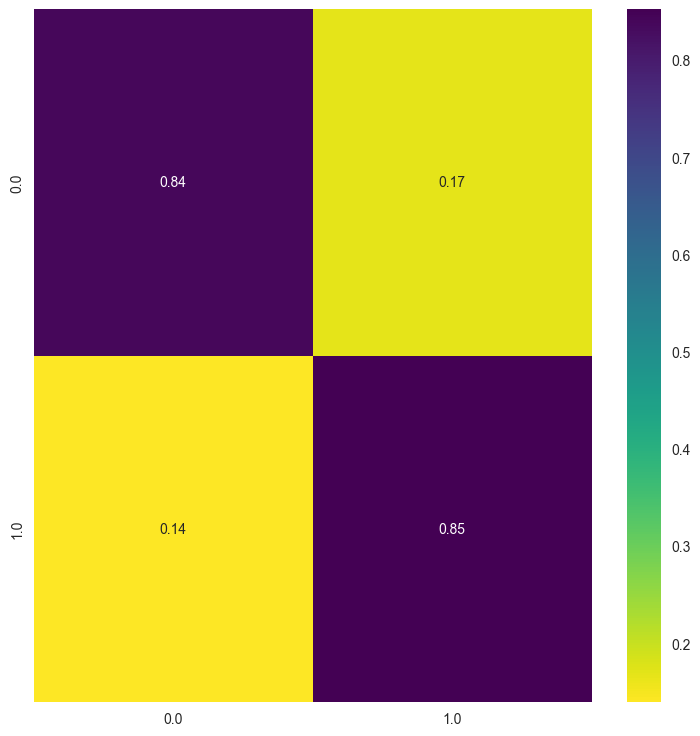

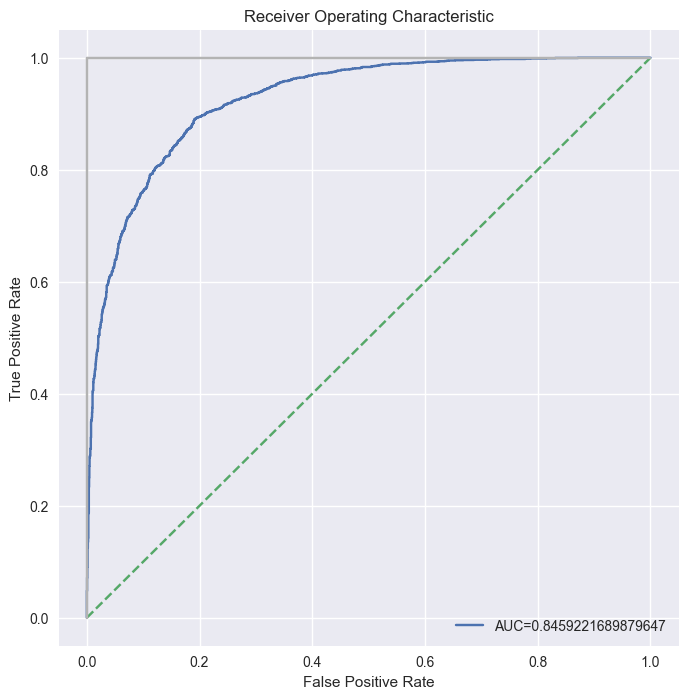

In [65]:
# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluation_function(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

After training the model on the increased training dataset for three epochs, the model performed well on the test set with a Recall score of 85.93%, Precision score of 83.46%, Accuracy score of 84.58% and a Macro Averaged F1-score of 84.58%. The ROC-curve also looks quite healthy, so this makes distilbert a good candidate. Still the performance didn't increase substantially, so I will experiment with another BERT model below.

### BERT Large Cased Model

The next model I'll be trialing is BERT-large cased. The reason I'll be using the cased version is that I have a suspicion that the letter casing of words could potentially impact the emotional tone of the sentence. 

Note that to trial this I run again the initial cells for the dataset splitting to get only the 0.32 of the data for training, since when I tried with the large BERT model and the large dataset it was unable to run in my machine. 

In [20]:
# Load the BERT tokenizer large
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

Then defining the initial model architecture since there was no improvement with the simplified version. I replace here to use the BERT-large cased model and also add a softmax to the output of the linear stack.

In [10]:
# Classifier Model using BERT large cased
class BERT_04(nn.Module):
    
    def __init__(self, hidden_size, classes_size, dropout=0.1):
        super(BERT_04, self).__init__()
        self.model = BertModel.from_pretrained('bert-large-cased', return_dict=False)
        self.linear_stack = nn.Sequential(
            nn.Linear(self.model.config.hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, classes_size),
            nn.Softmax(dim=1)
        )

    def forward(self, input_ids, attention_mask): 
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return self.linear_stack(output[0][:,0,:])

Then training for one epoch since the size of this BERT model makes the training take a lot of time.

In [11]:
EPOCHS = 1
HIDDEN_SIZE = 62
CLASSES = 2
DROPOUT = 0.13
LEARNING_RATE = 5e-5
EPSILON = 1e-8
CLIP_VALUE = 0.8

# Instaniate the model
seedTorch()
model = BERT_04(HIDDEN_SIZE, CLASSES, DROPOUT).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
model = train_model(EPOCHS,optimizer, scheduler, train_dataloader, lossfunc, model, device, True, CLIP_VALUE)
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')


Epoch 1
_________________________________
loss: 0.695161  [    0/14402]
loss: 0.552598  [ 2048/14402]
loss: 0.514421  [ 4096/14402]
loss: 0.497088  [ 6144/14402]
loss: 0.493414  [ 8192/14402]
loss: 0.476213  [10240/14402]
loss: 0.552749  [12288/14402]
loss: 0.514003  [14336/14402]
_________________________________
Training Time: 31.62 minutes


Then evaluation on the test set.


Evaluation Results
_________________________________
Predicted 3010 / 3601 correctly
Mean Loss: 0.47 
Recall: 83.14%
Precision: 84.02%
Accuracy: 83.59%
Macro Averaged F1-score: 83.59%
_________________________________


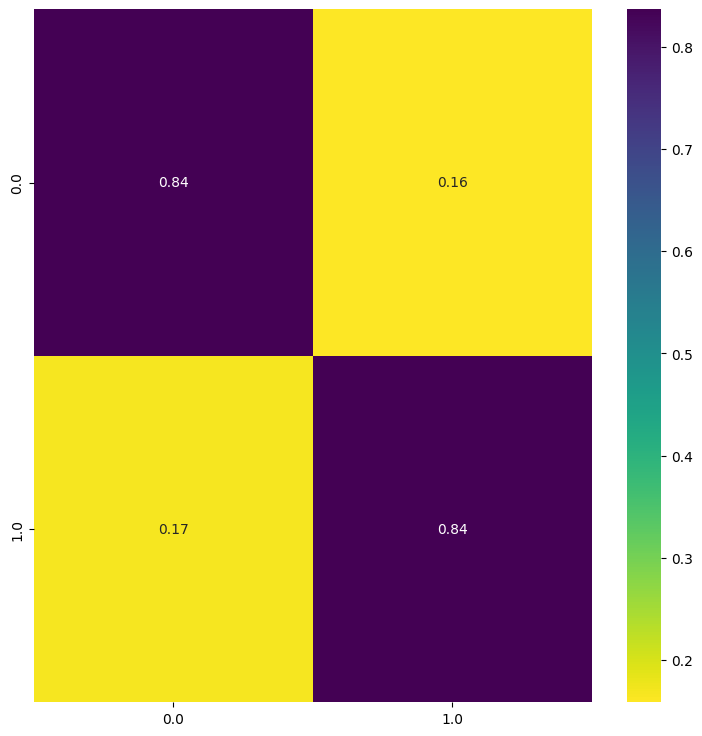

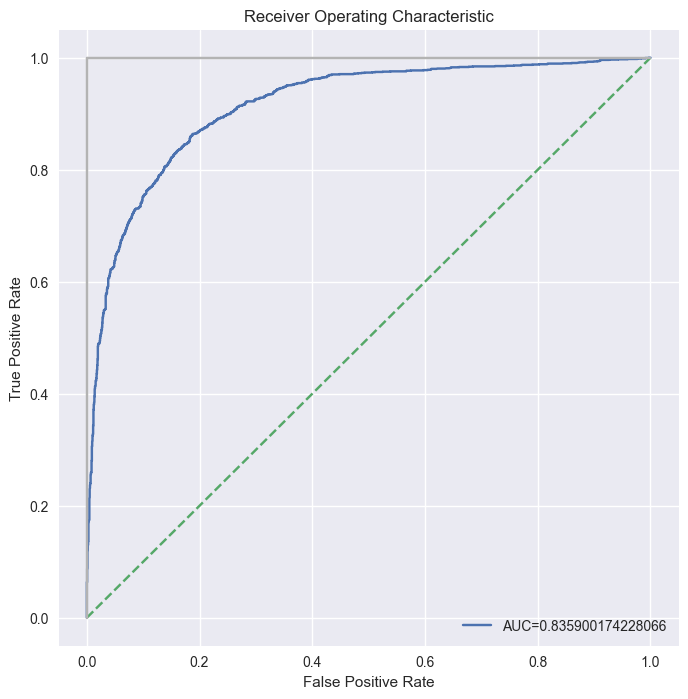

In [12]:
# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluation_function(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Despite using the reduced dataset and training for only one epoch, the BERT-large cased model achieved a respectable performance with an accuracy of 83.59%, recall of 83.14%, precision of 84.02% and macro averaged F1-score of 83.59%.

### DistilBERT Stanford Model

Finally, I will examine the performance of the DistilBERT model fine-tuned on the Stanford Sentiment Treebank dataset. I won't use this as my final model, but I want to investigate how a model that is already tuned for sentiment analysis does in this dataset and how it compares to the models I've been using so far.

In [6]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

Given that this model is designed specifically for sentiment analysis, I will use the simplified network architecture.

In [7]:
# Classifier Model using BERT distilled
class BERT_05(nn.Module):
    
    def __init__(self, classes_size, dropout=0.1):
        super(BERT_05, self).__init__()
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", return_dict=False)
        self.linear_stack = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.model.config.hidden_size, classes_size),
            nn.Softmax(dim=1)
        )

    def forward(self, input_ids, attention_mask): 
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return self.linear_stack(output[0][:,0,:])

I also will use 60% of the data for training since with distilBERT allows for this increased size to work in my local machine.

In [10]:
# I will reserve 10% of the samples for testing and 10% for validation
train_X, val_X, test_X = X[:int(len(X)*0.6)], X[int(len(X)*0.6):int(len(X)*0.7)], X[int(len(X)*0.7):int(len(X)*0.8)]
train_Y, val_Y, test_Y = Y[:int(len(Y)*0.6)], Y[int(len(Y)*0.6):int(len(Y)*0.7)], Y[int(len(Y)*0.7):int(len(Y)*0.8)]

# Unique returns the mapping sorted
labelsMapping, indexed_labels_train = np.unique(train_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_val = np.unique(val_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_test = np.unique(test_Y['rating'], return_inverse=True)

MAX_LENGTH = 64
BATCH_SIZE = 32

# Tokenizing, preprocessing and dataset creation
train_dataset = CustomDataset(train_X, indexed_labels_train, MAX_LENGTH)
val_dataset = CustomDataset(val_X, indexed_labels_val, MAX_LENGTH)
test_dataset = CustomDataset(test_X, indexed_labels_test, MAX_LENGTH)

# Corresponding Dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Then training the model for 3 epochs and I expect it to need no fine-tuning since it's already trained for sentiment analysis.

Epoch 1
__________________________________
loss: 0.617329  [    0/27004]
loss: 0.622576  [ 2048/27004]
loss: 0.430606  [ 4096/27004]
loss: 0.539471  [ 6144/27004]
loss: 0.443699  [ 8192/27004]
loss: 0.451051  [10240/27004]
loss: 0.682509  [12288/27004]
loss: 0.534728  [14336/27004]
loss: 0.545880  [16384/27004]
loss: 0.378819  [18432/27004]
loss: 0.466348  [20480/27004]
loss: 0.564726  [22528/27004]
loss: 0.433102  [24576/27004]
loss: 0.393210  [26624/27004]

Evaluation Results
_________________________________
Predicted 3678 / 4501 correctly
Mean Loss: 0.49 
Recall: 83.60%
Precision: 80.71%
Accuracy: 81.72%
Macro Averaged F1-score: 81.71%
_________________________________
Training loss:  0.5018214739823793  Validation loss:  0.48527456809442937  Accuracy:  81.71517440568763
__________________________________
Epoch 2
__________________________________
loss: 0.507042  [    0/27004]
loss: 0.407830  [ 2048/27004]
loss: 0.410517  [ 4096/27004]
loss: 0.460558  [ 6144/27004]
loss: 0.388189  

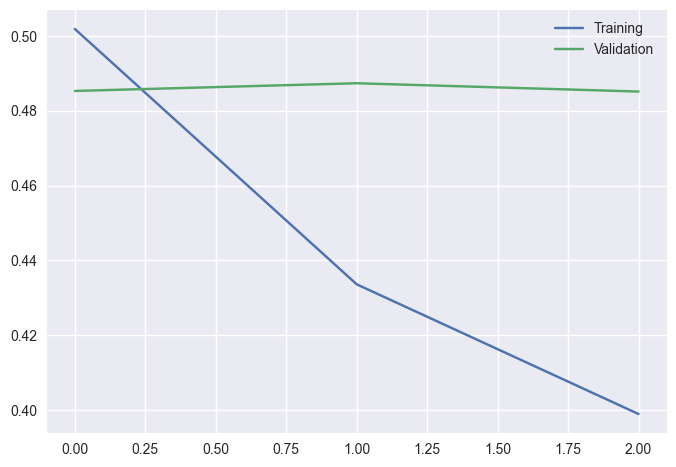

Best F1 score after  2  epochs.
Training Time: 17.31 minutes


In [14]:
EPOCHS = 3
CLASSES = 2
DROPOUT = 0.1
LEARNING_RATE = 5e-5
EPSILON = 1e-8
CLIP_VALUE = 1.0

# Instaniate the model
model = BERT_05(CLASSES, DROPOUT).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
best_epoch = optimal_model(device, model, EPOCHS, train_dataloader, val_dataloader, optimizer, scheduler, lossfunc, True, CLIP_VALUE)
print("Best F1 score after ", best_epoch, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

Unsurprisingly, the best snapshot using this distilBERT model is after only 2 epochs. Also from the learning curve it is obvious that the model after this point is starting to overfit, while the validation line looks stable with minimal differences in performance. Then I will evaluate on the test set.


Evaluation Results
_________________________________
Predicted 3754 / 4501 correctly
Mean Loss: 0.47 
Recall: 85.20%
Precision: 81.67%
Accuracy: 83.40%
Macro Averaged F1-score: 83.40%
_________________________________


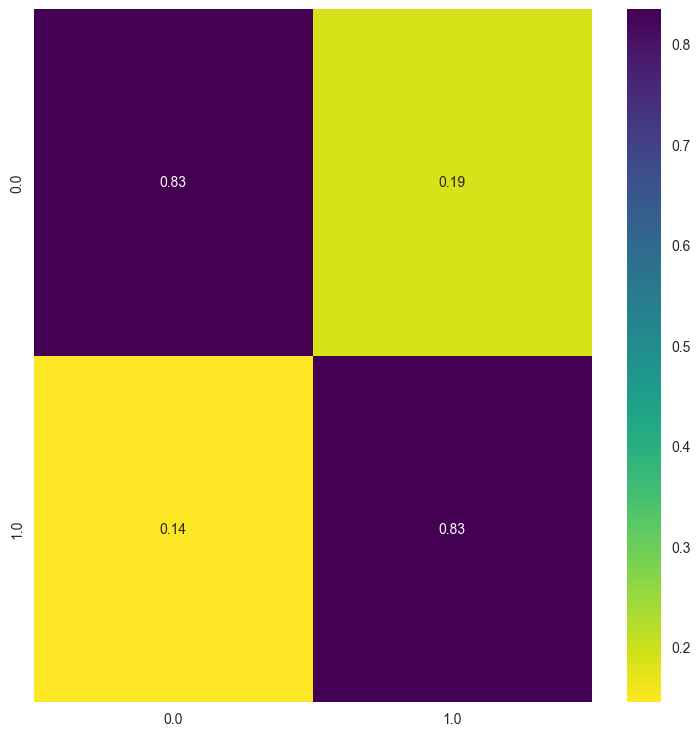

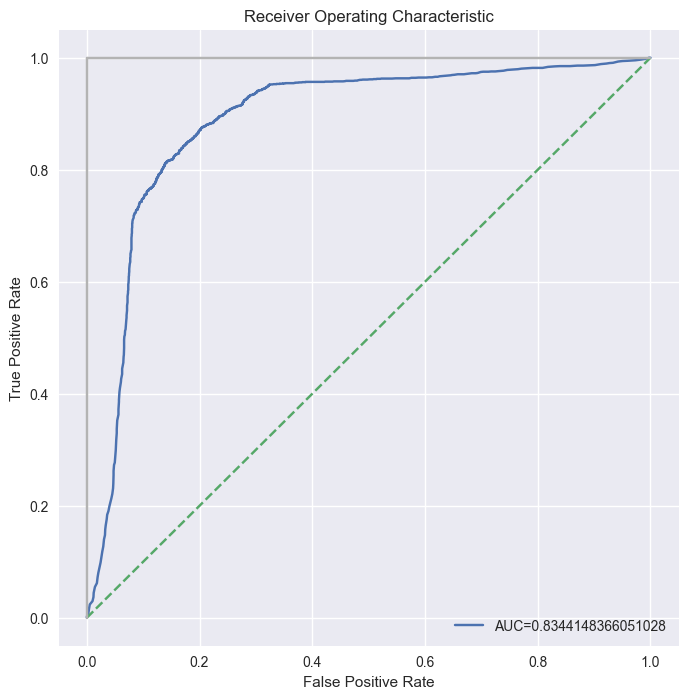

In [15]:
# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluation_function(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The Distilbert Stanford Sentiment Treebank model achieved a relatively good accuracy of 83.40% and similar F1 score, that takes into account both precision and recall. The ROC curve though is rather abrupt in its angle and this is highlighted by the high recall and low precision of the model, which indicates that the model is good at identifying most of the positive samples, but tends to identify some negative sentiment as positive. But it's good to see that the models I've been using so far are better.

In conclusion, for my final BERT-based classifier I will use the BERT cased model which showed the best performance among the models tested. This time though I will use the base rather than the large one to allow for an increased dataset and a longer maximum length for better sentiment prediction and better generalization ability.